In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import linalg
from tensorly.base import unfold
from tensorly.decomposition import tucker

import tensor_utils as utils

np.random.seed(14159)

# Parameters & Model

In [50]:
# Parameters
d = 4
n = np.array([50, 60, 70, 80])
r = np.array([2, 2, 2, 2])
frobH = 20

N = np.sum(n)
c = n/N
setting = "$\\mathbf{{n}} = {{{}}}^\\top \\quad \\mathbf{{r}} = {{{}}}^\\top \\quad ||\\mathbf{{H}}||_F = {{{}}}$".format(list(n), list(r), frobH)

In [51]:
# Model
H = np.random.randn(*r)
H = frobH*H/utils.frob(H)
X = [linalg.orth(np.random.randn(n[j], r[j])) for j in range(d)]
Z = np.random.randn(*n)
P = utils.tucker_prod(H, X)
T = P+Z/np.sqrt(N)
G, U = tucker(T, r, verbose=True)

reconstruction error=0.9969039677885909, variation=2.9422009273361027e-10.
converged in 2 iterations.


# Computations

In [52]:
def get_LSD(i, xmin, xmax):
    xx = np.linspace(xmin, xmax, 200)
    Em, Ep = (np.sqrt(c[i])-np.sqrt(np.prod(c)*(N**(d-2))/c[i]))**2, (np.sqrt(c[i])+np.sqrt(np.prod(c)*(N**(d-2))/c[i]))**2
    mask = (xx > Em) & (xx < Ep)
    LSD = np.zeros_like(xx)
    LSD[mask] = np.sqrt((xx[mask]-Em)*(Ep-xx[mask]))/(2*np.pi*xx[mask]*c[i])
    return xx, LSD

In [53]:
P_unfold, T_unfold = [], []
spT, LSD = [], []
s2, ksi, Xt, zeta = [], [], [], []
for i in tqdm(range(d)):
    T_unfold.append(unfold(T, i)) # unfold T along mode i
    spT.append(linalg.eigh(T_unfold[i]@T_unfold[i].T)) # compute ESD and empirical eigenvectors
    LSD.append(get_LSD(i, *utils.plot_interv(spT[i][0].min(), spT[i][0].max(), alpha=.1))) # compute LSD
    P_unfold.append(unfold(P, i)) # unfold P along mode i
    evals, evecs = linalg.eigh(P_unfold[i]@P_unfold[i].T) # get eigenvalues and eigenvectors
    s2.append(evals[-r[i]:])
    Xt.append(evecs[:, -r[i]:])
    prod = np.prod(n)/(N*n[i])
    ksi.append((c[i]+s2[i])*(s2[i]+prod)/s2[i]) # compute spikes positions
    zeta.append(((c[i]-prod)-(1+prod/s2[i])*(c[i]-s2[i]))/(c[i]+s2[i])) # compute eigenvectors alignments

100%|██████████| 4/4 [00:00<00:00,  7.69it/s]


# Plots

In [59]:
i = -1

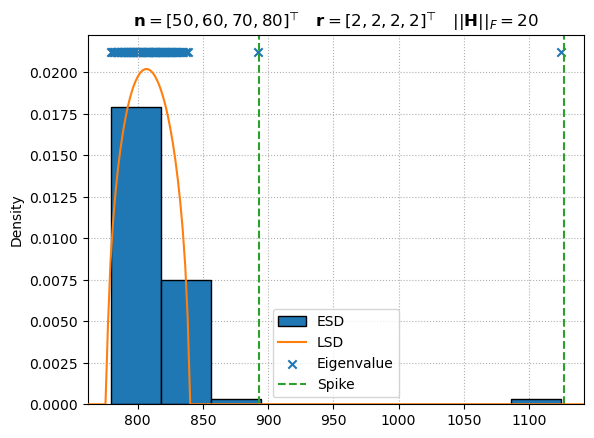

In [60]:
# Spectral distribution
plt.hist(spT[i][0], density=True, bins='sqrt', edgecolor='black', zorder=2, label="ESD")
plt.plot(LSD[i][0], LSD[i][1], color='C1', zorder=3, label="LSD")
ymin, ymax = plt.ylim()
plt.scatter(spT[i][0], [ymax]*n[i], marker='x', label="Eigenvalue")
vline = None
for k in range(r[i]):
    vline = plt.axvline(x=ksi[i][k], color='C2', ls='--')
if vline:
    vline.set_label("Spike")
plt.xlim(LSD[i][0][0], LSD[i][0][-1])
plt.grid(ls=':')
plt.ylabel("Density")
plt.legend()
plt.title(setting);

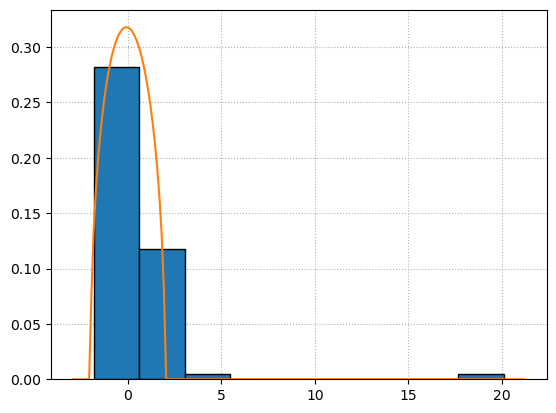

In [61]:
tilde = lambda x: (x-(c[i]+np.prod(n)/(N*n[i])))/np.sqrt(np.prod(c)*(N**(d-2)))
plt.hist(tilde(spT[i][0]), density=True, bins='sqrt', edgecolor='black', zorder=2, label="ESD")
plt.plot(tilde(LSD[i][0]), LSD[i][1]/np.sum(np.diff(tilde(LSD[i][0]))*(LSD[i][1][1:]+LSD[i][1][:-1])/2), color='C1', zorder=3, label="LSD")
plt.grid(ls=':')

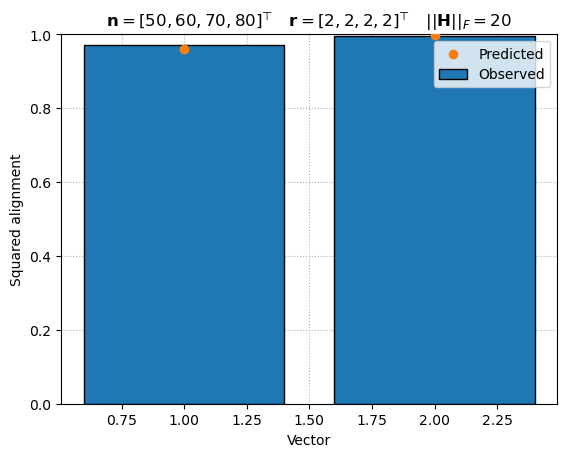

In [62]:
# Eigenvector alignments
xr = np.arange(1, r[i]+1)
plt.bar(xr, np.sort(np.max((Xt[i].T@spT[i][1][:, -r[i]:])**2, axis=0)), edgecolor='black', zorder=2, label="Observed")
plt.scatter(xr, zeta[i], marker='o', zorder=3, label="Predicted")
plt.grid(ls=':')
plt.ylim(0, 1)
plt.xlabel("Vector")
plt.ylabel("Squared alignment")
plt.legend()
plt.title(setting);

C:\Users\hug97\AppData\Local\Temp\ipykernel_17856\560052324.py:1: RuntimeWarning: divide by zero encountered in true_divide
  zf = lambda i, s2: np.maximum(0, ((c[i]-np.prod(n)/(N*n[i]))-(1+np.prod(n)/(N*n[i]*s2))*(c[i]-s2))/(c[i]+s2))


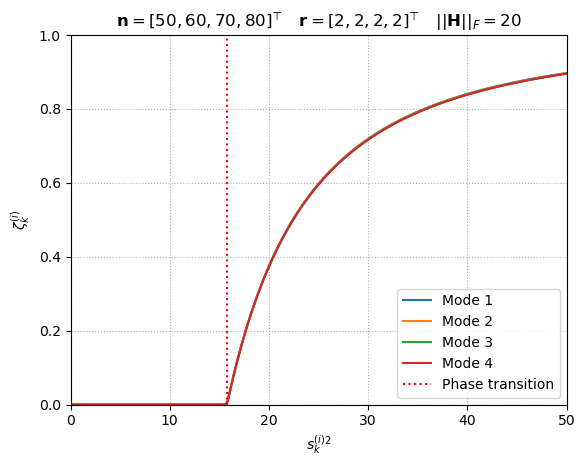

In [64]:
zf = lambda i, s2: np.maximum(0, ((c[i]-np.prod(n)/(N*n[i]))-(1+np.prod(n)/(N*n[i]*s2))*(c[i]-s2))/(c[i]+s2))
s2r = np.linspace(0, 50, 200)
for j in range(d):
    plt.plot(s2r, zf(j, s2r), label="Mode {}".format(j+1))
plt.axvline(x=np.sqrt(np.prod(c)*(N**(d-2))), ls=':', color='red', label="Phase transition")
plt.grid(ls=':')
plt.xlim(s2r[0], s2r[-1])
plt.ylim(0, 1)
plt.xlabel("${s^{(i)}_k}^2$")
plt.ylabel("$\\zeta^{(i)}_k$")
plt.legend()
plt.title(setting);